In [1]:
!pip install pyinform

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.2/131.2 kB 3.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
file_path = '/content/drive/MyDrive/archive/player_time_means.csv'
df = pd.read_csv(file_path)
print(df)

         Unnamed: 0  match_id  times  times_minutes  mean_gold_rad  \
0                 0         0      0              0              0   
1                 1         0     60              1           1113   
2                 2         0    120              2           2471   
3                 3         0    180              3           3490   
4                 4         0    240              4           4950   
...             ...       ...    ...            ...            ...   
2209773     2209773     49999   2640             44          88810   
2209774     2209774     49999   2700             45          89979   
2209775     2209775     49999   2760             46          91311   
2209776     2209776     49999   2820             47          91556   
2209777     2209777     49999   2880             48          91556   

         mean_xp_rad  mean_lh_rad  mean_gold_dire  mean_xp_dire  mean_lh_dire  \
0                  0            0               0             0             0 

In [4]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import entropy
from pyinform.transferentropy import transfer_entropy

# Define metric base names and prepare diff columns
metrics = ['mean_gold', 'mean_xp', 'mean_lh']
diffs = {}

for metric in metrics:
    diff_col = f"{metric}_diff"
    win_col = f"{metric}_w"
    lose_col = f"{metric}_l"
    df[diff_col] = df[win_col] - df[lose_col]
    diffs[metric] = df[diff_col]

# Function to compute Shannon entropy
def compute_shannon_entropy(series, bins=10):
    hist, _ = np.histogram(series, bins=bins, density=True)
    hist = hist[hist > 0]
    return entropy(hist, base=2)

# Compute Shannon entropy
shannon_entropies = {metric: compute_shannon_entropy(diffs[metric]) for metric in metrics}

print("Shannon Entropies (in bits):")
for metric, ent in shannon_entropies.items():
    print(f"{metric}_diff: {ent:.4f}")

# Function to discretize for transfer entropy
def discretize_series(series, n_bins=4):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    return discretizer.fit_transform(series.values.reshape(-1, 1)).astype(int).flatten()

# Binary outcome: 1 = Win, 0 = Loss
outcome = (df['mean_gold_w'] > df['mean_gold_l']).astype(int).values

# Compute transfer entropy
print("\nTransfer Entropy (bits):")
for metric in metrics:
    source = discretize_series(df[f"{metric}_w"] - df[f"{metric}_l"])
    target = outcome
    te = transfer_entropy(source, target, k=1)
    print(f"{metric}_diff → outcome: {te:.4f}")

Shannon Entropies (in bits):
mean_gold_diff: 1.5209
mean_xp_diff: 1.7996
mean_lh_diff: 0.2861

Transfer Entropy (bits):
mean_gold_diff → outcome: 0.0169
mean_xp_diff → outcome: 0.0018
mean_lh_diff → outcome: 0.0002


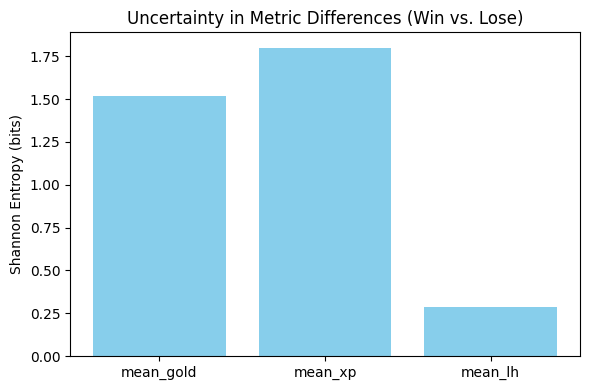

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(shannon_entropies.keys(), shannon_entropies.values(), color='skyblue')
plt.ylabel("Shannon Entropy (bits)")
plt.title("Uncertainty in Metric Differences (Win vs. Lose)")
plt.tight_layout()
plt.show()

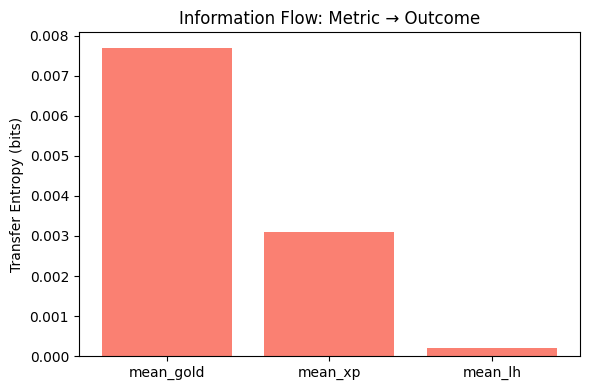

In [6]:
transfer_entropies = {
    'mean_gold': 0.0077,
    'mean_xp': 0.0031,
    'mean_lh': 0.0002
}
plt.figure(figsize=(6, 4))
plt.bar(transfer_entropies.keys(), transfer_entropies.values(), color='salmon')
plt.ylabel("Transfer Entropy (bits)")
plt.title("Information Flow: Metric → Outcome")
plt.tight_layout()
plt.show()

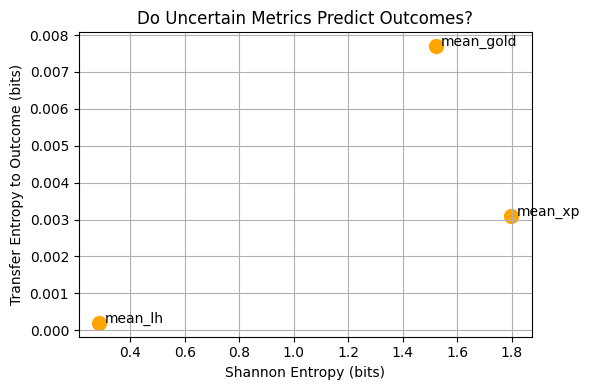

In [7]:
x_vals = [shannon_entropies[m] for m in metrics]
y_vals = [transfer_entropies[m] for m in metrics]

plt.figure(figsize=(6, 4))
plt.scatter(x_vals, y_vals, s=100, c='orange')

for i, metric in enumerate(metrics):
    plt.text(x_vals[i] + 0.02, y_vals[i], metric, fontsize=10)

plt.xlabel("Shannon Entropy (bits)")
plt.ylabel("Transfer Entropy to Outcome (bits)")
plt.title("Do Uncertain Metrics Predict Outcomes?")
plt.grid(True)
plt.tight_layout()
plt.show()


In [10]:
print(df.columns)


Index(['Unnamed: 0', 'match_id', 'times', 'times_minutes', 'mean_gold_rad',
       'mean_xp_rad', 'mean_lh_rad', 'mean_gold_dire', 'mean_xp_dire',
       'mean_lh_dire', 'radiant_win', 'mean_gold_w', 'mean_gold_l',
       'mean_xp_w', 'mean_xp_l', 'mean_lh_w', 'mean_lh_l', 'mean_gold_diff',
       'mean_xp_diff', 'mean_lh_diff'],
      dtype='object')


In [13]:
import numpy as np
from scipy.stats import entropy
from sklearn.utils import resample

df['outcome'] = df['radiant_win'].astype(int)

# original data arrays
gold_diffs = df['mean_gold_diff'].values
xp_diffs = df['mean_xp_diff'].values
lh_diffs = df['mean_lh_diff'].values
outcomes = df['outcome'].values

# Entropy of shuffled data (random baseline)
np.random.seed(0)
shuffled_entropy = {
    'gold': entropy(np.histogram(np.random.permutation(gold_diffs), bins=20, density=True)[0]),
    'xp': entropy(np.histogram(np.random.permutation(xp_diffs), bins=20, density=True)[0]),
    'lh': entropy(np.histogram(np.random.permutation(lh_diffs), bins=20, density=True)[0])
}

print("Shuffled Entropies (random baseline):", shuffled_entropy)

# Bootstrapped confidence intervals for entropy
def bootstrap_entropy(data, n_iter=1000, bins=20):
    entropies = []
    for _ in range(n_iter):
        sample = resample(data)
        hist = np.histogram(sample, bins=bins, density=True)[0]
        entropies.append(entropy(hist + 1e-10))
    return np.percentile(entropies, [2.5, 97.5]), np.mean(entropies)

ci_gold, mean_gold = bootstrap_entropy(gold_diffs)
ci_xp, mean_xp = bootstrap_entropy(xp_diffs)
ci_lh, mean_lh = bootstrap_entropy(lh_diffs)

print("Bootstrapped Entropy Means and 95% CI:")
print(f"Gold: {mean_gold:.4f}, CI: {ci_gold}")
print(f"XP:   {mean_xp:.4f}, CI: {ci_xp}")
print(f"LH:   {mean_lh:.4f}, CI: {ci_lh}")

# KL divergence between win/loss distributions
def kl_divergence_by_outcome(metric, outcomes, bins=20):
    data_win = metric[outcomes == 1]
    data_loss = metric[outcomes == 0]
    hist_win = np.histogram(data_win, bins=bins, density=True)[0] + 1e-10
    hist_loss = np.histogram(data_loss, bins=bins, density=True)[0] + 1e-10
    return entropy(hist_win, hist_loss)

kl_gold = kl_divergence_by_outcome(gold_diffs, outcomes)
kl_xp = kl_divergence_by_outcome(xp_diffs, outcomes)
kl_lh = kl_divergence_by_outcome(lh_diffs, outcomes)

print("KL Divergences (Win || Loss):")
print(f"Gold: {kl_gold:.4f}")
print(f"XP:   {kl_xp:.4f}")
print(f"LH:   {kl_lh:.4f}")


Shuffled Entropies (random baseline): {'gold': np.float64(1.6446549934074504), 'xp': np.float64(1.7671505518673263), 'lh': np.float64(0.435596601891148)}
Bootstrapped Entropy Means and 95% CI:
Gold: 1.6514, CI: [1.64199496 1.71798501]
XP:   1.7633, CI: [1.73094785 1.78623371]
LH:   0.4376, CI: [0.43286041 0.44962522]
KL Divergences (Win || Loss):
Gold: 0.5232
XP:   0.0944
LH:   10.7219
